# Store item demand forecasting
In this project, I will build a machine learning model to forecast 3 months of 50 items sales in 10 stores of a company. It involves supervised learning, using a labeled training set for regression.

I will use the following pipeline, based on CRISP-DM framework:

1. Define the business problem
2. Initial data understanding
3. Feature engineering and exploratory data analysis
4. Data cleaning and preprocessing
5. Modelling
6. Determine financial results

In this notebook, I will be covering steps 1 to 3 of the pipeline above. The main objective here is to assess the time series data (5 years of sales) trends, seasonal patterns and characteristics, which will guide the modelling step and provide valuable business insights. Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

# 1. Business problem

We are asked to forecast sales for 50 items across 10 stores over a three-month period.

Sales forecasting for 50 items across 10 stores over a three-month period involves utilizing historical sales data, market trends, and store-specific variables to predict future sales levels. This process enables businesses to strategically manage inventory, allocate resources effectively, and optimize sales strategies for each item and store, maximizing overall revenue and profitability.

Considering everything mentioned above, the project objectives are:
1. Identify valuable business insights about sales over time, like seasonal patterns, trends and general characteristics
2. Construct a model able to accurately predict the sales for 50 items across 10 stores over a three-month period
3. Determine financial results given by the project

As a result, the business problem will be resolved.

### Importing the libraries

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Plot grid styles.
sns.set_theme(style='whitegrid')

# 2. Initial data understanding
- The data covers 5 years (from 2013-01-01 to 2017-12-31) of 50 items sales across 10 stores.
- The dataset was collected from kaggle: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview
- In this step, I intend to initially understand the data, assessing its dimensions, features, features datatypes, descriptive statistics, missing values and duplicated values.

In [12]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


### Data dictionary
1. Date: The date of the sale.
2. Store: The store where the sale was made. Categorical nominal.
3. Item: The item sold. Categorical nominal.
4. Sales: The number of item units sold. Numeric discrete.

General information about the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 913000 rows and 4 columns.


Seems like there are no missing values and date is in incorrect data type (object -> datetime).

Some descriptive statistics.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


The average sales is 52.25 products. However, this value can vary a lot, looking at the standard deviation (28.8). Looks like we have records with 0 sales and outliers, considering a max sales of 231. Moreover, the mean is greater than the median, possibly indicating a right-skewed distribution.

Looking for missing and duplicated values.

In [9]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [10]:
df.duplicated().sum()

0

There are no missing and duplicated values in the data.

I will convert the date column to the correct data type (datetime) and set it as the dataset index in order to make data manipulation and visualization easier. In a forecasting task, the date column is very important. From the dates, other time series features will be created and we will be able to visualize the sales trends, seasonal patterns and characteristics over time.

In [14]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_values(by=['date', 'store', 'item'], inplace=True)
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [16]:
print(f'The data goes from {df.index.min()} to {df.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


# 3. Feature engineering and exploratory data analysis
In this step, I will create initial time series features (in the modelling step, more elaborated features will be created and different combinations of them will be tested) in order to extract useful information from the available attributes. After doing this, I will explore the data to uncover the time series trends, seasonal patterns and characteristics, specially regard to the sales.

In [18]:
def eda_time_series_features(data):

    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.float64)

    return df

In [19]:
df = eda_time_series_features(df)

In [20]:
df.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0


### Time series train-test-split
I will split the data into train and test sets before the EDA in order to get a more realistic representation. We want to forecast 3 months of future sales data we have never seen, so why would we explore this data? This will simulate the production environment. Once the objective is to predict 3 months of item demand, I will separate 3 months of data for the test. An important observation here is that I will divide the data chronologically, using earlier data for training and later data for testing, ensuring the model predicts future events. Randomly splitting the data would lead to data leakage.

In [21]:
train = df.loc[df.index < '2017-09-30']
test = df.loc[df.index >= '2017-09-30']

In [22]:
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (866500, 10). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 10). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.


Let's visualize the time series train-test-split.

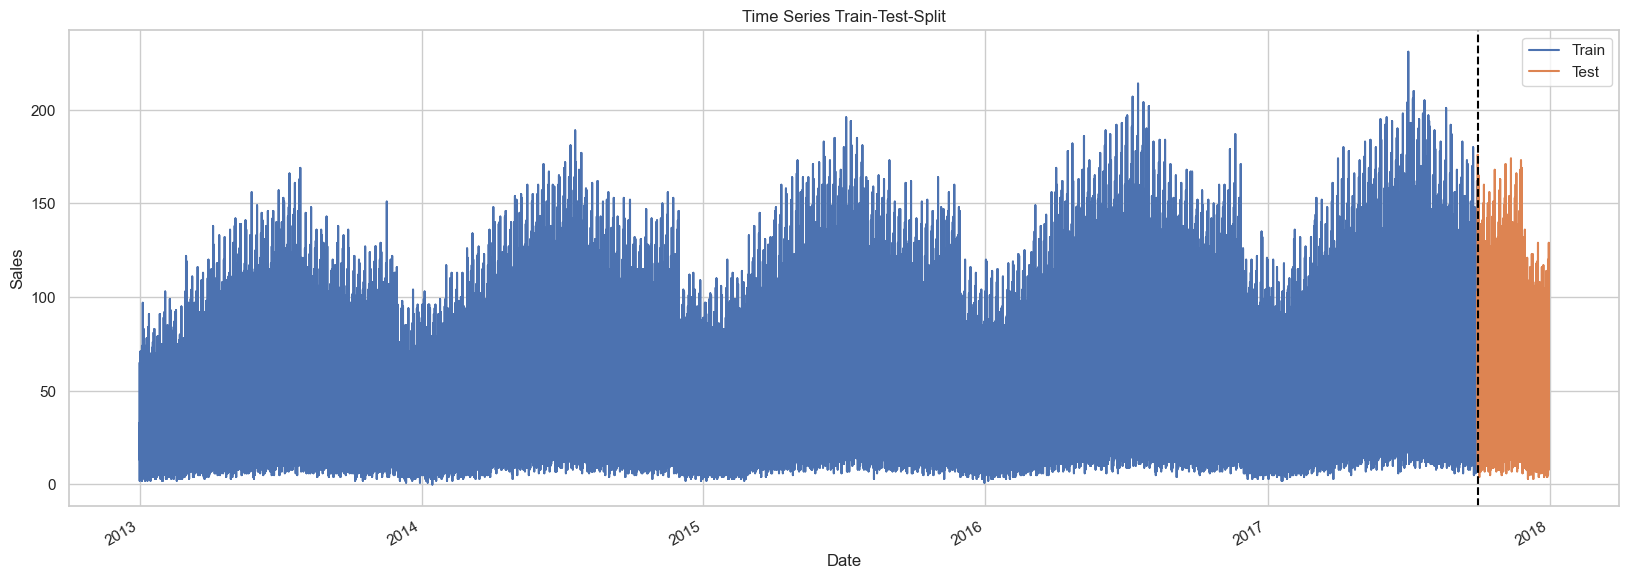

In [24]:
figure, ax = plt.subplots(figsize=(20, 7))

train.plot(ax=ax, label='Train', y='sales')
test.plot(ax=ax, label='Test', y='sales')

ax.axvline('2017-09-30', color='black', ls='--')

plt.title('Time Series Train-Test-Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Now let's explore the data.

In [26]:
print(f"There are {train['store'].nunique()} stores and {train['item'].nunique()} items.")

There are 10 stores and 50 items.


In [31]:
print(f'Number of items in each store: ')
train.groupby(['store'])['item'].nunique()

Number of items in each store: 


store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

There are 10 stores with 50 items.

Descriptive statistics for stores sales.

In [32]:
train.groupby(['store']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                               
       count      sum       mean median        std min  max
store                                                      
1      86650  4084466  47.137519   44.0  24.016892   1  155
2      86650  5792453  66.848852   62.0  33.618041   3  231
3      86650  5144873  59.375338   55.0  29.997813   3  196
4      86650  4744968  54.760162   51.0  27.749964   4  186
5      86650  3437398  39.669913   37.0  20.380008   2  130
6      86650  3433953  39.630156   37.0  20.325261   0  134
7      86650  3142532  36.266959   34.0  18.692075   1  122
8      86650  5542348  63.962470   59.0  32.250470   4  204
9      86650  4757040  54.899481   51.0  27.846524   4  195
10     86650  5074691  58.565389   54.0  29.577744   3  187

Stores 2 and 8 are the best ones. On average, they sold more products. Furthermore, they also presented the highest max products sold.

Descriptive statistics for each item.

In [33]:
train.groupby(['item']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     17330   380010  21.927871   21.0   8.493356   1   59
2     17330  1012599  58.430410   56.0  20.192987   9  150
3     17330   633098  36.531910   35.0  13.216580   7  104
4     17330   380462  21.953953   21.0   8.431758   0   66
5     17330   317239  18.305770   18.0   7.283992   1   50
6     17330  1011459  58.364628   56.0  20.281721  11  148
7     17330  1011628  58.374380   56.0  20.226265  11  141
8     17330  1329587  76.721696   74.0  26.209976  15  181
9     17330   888735  51.283035   49.0  17.854111   6  134
10    17330  1265509  73.024178   70.0  24.919198  14  175
11    17330  1203177  69.427409   67.0  23.823559  11  170
12    17330  1203732  69.459435   67.0  23.853727  12  170
13    17330  1457588  84.107790   81.0  28.432361  20  210
14    17330  1013910  58.506059   56.0  20.160745  12  152
15    17330  1521320  87.785343   84.0  29.629535  17  231
16    17330   443668  25.601154   25.0   9.623896   2   70
17    17330   570550  32.922677   32.0  12.019029   4   83
18    17330  1456620  84.051933   81.0  28.538608  18  208
19    17330   697532  40.249971   39.0  14.388879   5   99
20    17330   821210  47.386613   46.0  16.561348   9  127
21    17330   696886  40.212695   39.0  14.385391   7  109
22    17330  1391386  80.287709   77.0  27.236912  14  214
23    17330   506243  29.211945   28.0  10.845216   3   81
24    17330  1141556  65.871668   63.0  22.603871  14  156
25    17330  1394812  80.485401   77.0  27.346004  18  193
26    17330   823589  47.523889   46.0  16.796210   8  119
27    17330   381346  22.004962   21.0   8.498972   1   59
28    17330  1518790  87.639354   84.0  29.607440  16  206
29    17330  1203371  69.438604   67.0  23.713725  15  173
30    17330   697548  40.250894   39.0  14.421651   5  115
31    17330  1013684  58.493018   56.0  20.206133  10  159
32    17330   759910  43.849394   42.0  15.609326   5  119
33    17330  1202717  69.400866   67.0  23.809616  15  169
34    17330   444684  25.659781   25.0   9.638333   2   79
35    17330  1137423  65.633179   63.0  22.559962  12  168
36    17330  1331062  76.806809   74.0  26.157530  16  188
37    17330   505633  29.176746   28.0  10.795455   3   74
38    17330  1391199  80.276919   77.0  27.214937  15  188
39    17330   758314  43.757299   42.0  15.553706   7  112
40    17330   505427  29.164859   28.0  10.858684   3   74
41    17330   380516  21.957069   21.0   8.415531   2   60
42    17330   634286  36.600462   35.0  13.261404   5   96
43    17330   886269  51.140739   49.0  17.853993   9  126
44    17330   508009  29.313849   28.0  10.830966   3   78
45    17330  1393002  80.380958   77.0  27.445913  18  205
46    17330  1013189  58.464455   56.0  20.286005  11  150
47    17330   380371  21.948702   21.0   8.449978   2   61
48    17330   887318  51.201269   49.0  17.949133   8  130
49    17330   507336  29.275014   28.0  10.920223   3   77
50    17330  1139213  65.736469   63.0  22.508507  12  164

Items 28 and 15 are the most sold ones.

Now let's combine both, assessing descriptive statistics for each item sales in each store.

In [35]:
# train.groupby(['store', 'item']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

### Time series decomposition
-  Time series data is a sequence of data points indexed in time order, typically at uniform intervals, used to track changes over time and analyze trends, patterns, and seasonal variations.
- Time series decomposition: Analyze time series data by breaking it down into components. 
- Trend, seasonal, cyclical and residual components.
- A time series is stationary when its statistical characteristics, such as mean, variance and autocorrelation doesn't change over time.
- Understand the underlying patterns, trends and irregularities within the data.
- Trend Component: Underlying long-term progression or direction of the time series. Shows wheter the data is increasing, decreasing or remaining relatively constant over time.
- Seasonal Component: Regular, periodic fluctuations or patterns that occurs at specific intervals within the time series (annually, quarterly, monthly, and so on).
- Cyclical Component: Fluctuations in the time series that are not of a fixed period. Typically associated with business/economic cycles.
- Residual Component: Random fluctuations or irregularities that cannot be attributed to the trend, seasonal or cyclical patterns. Unexplained variability in the time series.
- In order to perform time series decomposition, I will use the statsmodels package, applying seasonal decomposition using moving averages.
- Moving Average: A moving average is a method that smooths data by creating averages from subsets of consecutive data points, providing a clearer picture of trends and patterns while reducing noise and short-term fluctuations.
- Approaches used to decompose a time series: Additive Model, Multiplicative Model.
- Additive Model: Time Series = Trend + Seasonal + Cyclical + Residual. The relation between the components is linear, constant variance over time.
- Multiplicative Model: Time Series = Trend * Seasonal * Cyclical * Residual. The relation between the components is non-linear, variance is not constant over time, changing with the level of the series.


<Figure size 640x480 with 0 Axes>

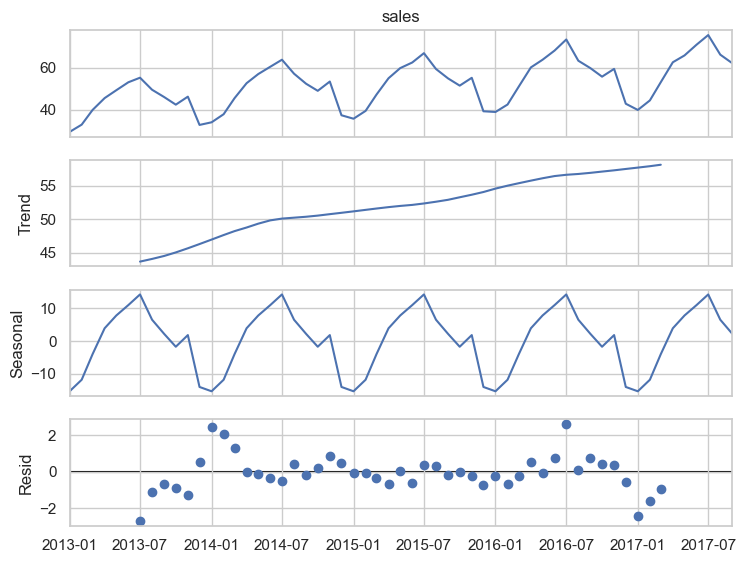

In [49]:
monthly_avg_sales = train['sales'].resample('MS').mean()
ts_decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales, model='additive')

fig = plt.figure()  
fig = ts_decomposition.plot()  
fig.set_size_inches(8, 6)

1. The time series is not stationary.
2. There is an increasing trend on sales over time.
3. There is seasonality. The sales are higher around july.
4. The residuals are randomly distributed around zero. This randomness suggests that the model is capturing most of the systematic patterns in the data.